# **Machine Learning Project - Pawpularity Swin Transformer and XGBoost Inference**
### Armando Fortes (2021403383), David Pissarra (2021403381)

In [1]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
from timm import create_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from fastai.vision.all import *
import gc
from xgboost import XGBRegressor
import optuna

### Constants

In [2]:
N_FOLDS = 10
EPOCHS = 5
PATIENCE = 2
SEED = 999
BATCH_SIZE = 32
NUM_WORKERS = 8

set_seed(SEED, reproducible=True)

dataset_path = Path('../input/petfinder-pawpularity-score/')

In [3]:
train_df = pd.read_csv(dataset_path/'train.csv')
train_df['path'] = train_df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,ebaaa8e384b3d2f0a56c7ff7675c154c,0,0,1,1,0,0,0,0,0,0,0,1,50,../input/petfinder-pawpularity-score/train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg
1,25e3bf4267c2dc3f579b779418221bb7,0,1,1,1,0,1,0,1,0,0,1,0,25,../input/petfinder-pawpularity-score/train/25e3bf4267c2dc3f579b779418221bb7.jpg
2,6548166fb3fda22b67881176397f0223,0,0,1,1,0,1,0,0,0,0,0,0,27,../input/petfinder-pawpularity-score/train/6548166fb3fda22b67881176397f0223.jpg
3,472c40116e1833555715e4774445ae5b,0,1,1,1,0,0,0,0,1,1,0,0,19,../input/petfinder-pawpularity-score/train/472c40116e1833555715e4774445ae5b.jpg
4,7b77e1a6d93667b575d57db83facd860,0,1,1,1,0,0,0,1,0,0,0,0,27,../input/petfinder-pawpularity-score/train/7b77e1a6d93667b575d57db83facd860.jpg


9912 images
Mean: 38.03904358353511
Median: 33.0
Standard deviation: 20.591990105774553


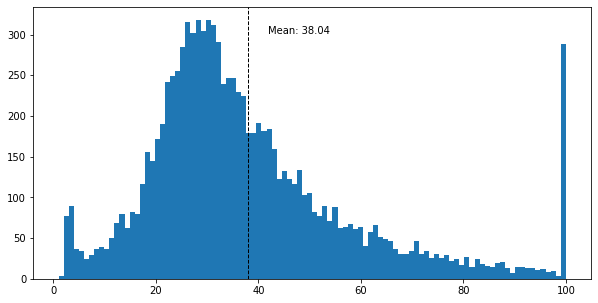

In [4]:
print(f"{len(train_df)} images")
train_df['Pawpularity'].hist(figsize = (10, 5), bins=100, grid=False)
plt.axvline(train_df['Pawpularity'].mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(train_df['Pawpularity'].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(train_df['Pawpularity'].mean()))
print(f"Mean: {train_df['Pawpularity'].mean()}")
print(f"Median: {train_df['Pawpularity'].median()}")
print(f"Standard deviation: {train_df['Pawpularity'].std()}")

In [5]:
train_df['norm_score'] = train_df['Pawpularity']/100
train_df['norm_score']

0       0.50
1       0.25
2       0.27
3       0.19
4       0.27
        ... 
9907    0.26
9908    0.65
9909    0.38
9910    0.44
9911    0.62
Name: norm_score, Length: 9912, dtype: float64

### Sturges' rule

In [6]:
num_bins = int(np.floor(1+np.log2(len(train_df))))

<AxesSubplot:>

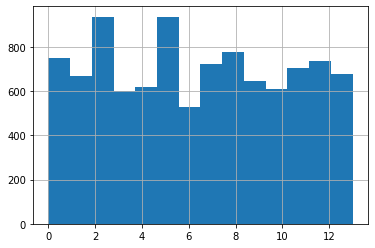

In [7]:
q = pd.qcut(train_df['norm_score'], num_bins, retbins=True, labels=False)
bin_limits = q[1]
train_df['bins'] = q[0]
train_df['bins'].hist(bins=num_bins)

In [8]:
train_df['fold'] = -1

skf = StratifiedKFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True)

for i, (_, val_index) in enumerate(skf.split(train_df.index, train_df['bins'])):
    train_df.iloc[val_index, -1] = i

In [9]:
final_val_df = train_df[train_df['fold'] == 9]
final_val_df.sort_values('Id', inplace=True)

train_df = train_df[train_df['fold'] != 9]

/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [10]:
def petfinder_rmse(input, target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [11]:
def get_fold(fold):
    fold_df = train_df[train_df['fold'] != fold]
    val_df = train_df[train_df['fold'] == fold]
    
    dls = ImageDataLoaders.from_df(fold_df,
                               valid_ds=val_df,
                               seed=SEED,
                               fn_col='path',
                               label_col='norm_score',
                               y_block=RegressionBlock,
                               bs=BATCH_SIZE,
                               num_workers=NUM_WORKERS,
                               item_tfms=Resize(224),
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()]))
    
    return dls

In [12]:
def get_learner(fold):
    model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=fold.c)

    learn = Learner(fold, model, loss_func=BCEWithLogitsLossFlat(), metrics=petfinder_rmse).to_fp16()
    
    return learn

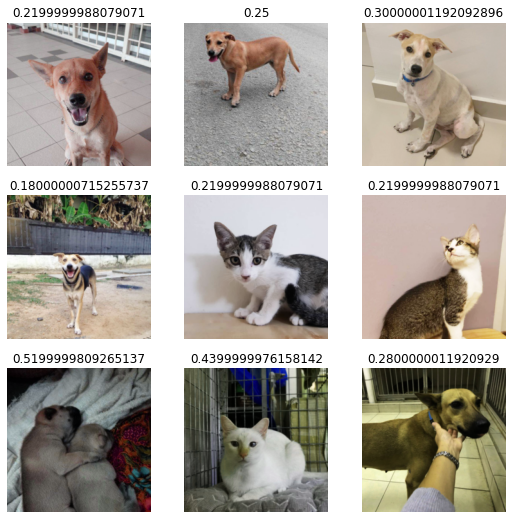

In [13]:
dls = get_fold(0)
dls.show_batch()

In [14]:
# Making pretrained weights work without needing to find the default filename
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'

In [15]:
test_df = pd.read_csv(dataset_path/'test.csv')
test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100

Swin - Training fold 0


/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.650059,0.646135,18.965069,05:19
1,0.646833,0.638836,18.105196,05:19
2,0.631147,0.637882,17.955940,05:19
3,0.621256,0.638191,17.974468,05:18
4,0.616434,0.639776,18.113907,05:18


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6461349725723267.
Better model found at epoch 1 with valid_loss value: 0.6388356685638428.
Better model found at epoch 2 with valid_loss value: 0.6378824710845947.
No improvement since epoch 2: early stopping


Swin - Training fold 1


/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.652134,0.655415,19.579245,05:19
1,0.641864,0.649912,18.814125,05:19
2,0.632365,0.651787,18.938246,05:18
3,0.620952,0.649457,18.621984,05:18
4,0.610425,0.652197,18.884405,05:19


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6554147601127625.
Better model found at epoch 1 with valid_loss value: 0.6499122977256775.
Better model found at epoch 3 with valid_loss value: 0.6494570374488831.


Swin - Training fold 2


/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.651946,0.649865,18.815441,05:19
1,0.641301,0.644485,18.045069,05:18
2,0.629904,0.645003,18.113144,05:19
3,0.611087,0.645823,18.134790,05:19


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6498648524284363.
Better model found at epoch 1 with valid_loss value: 0.6444850564002991.
No improvement since epoch 1: early stopping


Swin - Training fold 3


/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.655124,0.648833,18.211456,05:19
1,0.644892,0.643179,17.452675,05:19
2,0.635420,0.643642,17.481007,05:19
3,0.632128,0.643752,17.469366,05:19


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6488325595855713.
Better model found at epoch 1 with valid_loss value: 0.6431786417961121.
No improvement since epoch 1: early stopping


Swin - Training fold 4


/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.649490,0.642758,17.553684,05:19
1,0.641865,0.641934,17.447332,05:19
2,0.632530,0.639161,17.094217,05:18
3,0.616654,0.639626,17.028547,05:18
4,0.606421,0.640440,17.104271,05:18


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6427580118179321.
Better model found at epoch 1 with valid_loss value: 0.6419335603713989.
Better model found at epoch 2 with valid_loss value: 0.6391609907150269.


Swin - Training fold 5


/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.649681,0.653534,19.222446,05:20
1,0.644169,0.642837,17.845177,05:19
2,0.632548,0.642880,17.776281,05:19
3,0.617607,0.642099,17.742363,05:19
4,0.604607,0.643290,17.839783,05:18


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6535336375236511.
Better model found at epoch 1 with valid_loss value: 0.6428368091583252.
Better model found at epoch 3 with valid_loss value: 0.6420992612838745.


Swin - Training fold 6


/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.650328,0.640600,17.319027,05:19
1,0.643666,0.638529,17.030682,05:19
2,0.634648,0.638183,16.934431,05:18
3,0.624639,0.640665,17.226843,05:18
4,0.616235,0.640556,17.164034,05:18


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6405998468399048.
Better model found at epoch 1 with valid_loss value: 0.6385287642478943.
Better model found at epoch 2 with valid_loss value: 0.6381828784942627.
No improvement since epoch 2: early stopping


Swin - Training fold 7


/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.650225,0.644225,17.854212,05:18
1,0.648198,0.641816,17.522734,05:17
2,0.636689,0.641388,17.499472,05:18
3,0.621964,0.641792,17.464199,05:19
4,0.612111,0.644415,17.708376,05:18


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6442247629165649.
Better model found at epoch 1 with valid_loss value: 0.6418157815933228.
Better model found at epoch 2 with valid_loss value: 0.6413879990577698.


Swin - Training fold 8


/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.649202,0.647004,18.327709,05:18
1,0.642766,0.645701,18.079311,05:17
2,0.634275,0.640530,17.458193,05:18
3,0.619942,0.643116,17.738487,05:19
4,0.607749,0.644607,17.877129,05:20


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6470041275024414.
Better model found at epoch 1 with valid_loss value: 0.6457010507583618.
Better model found at epoch 2 with valid_loss value: 0.6405302286148071.
No improvement since epoch 2: early stopping


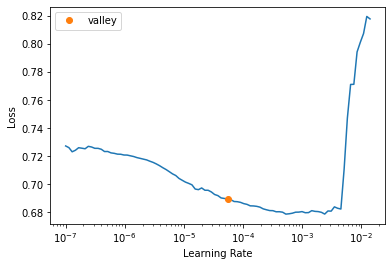

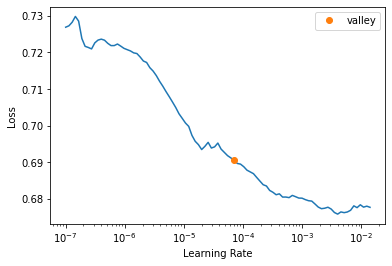

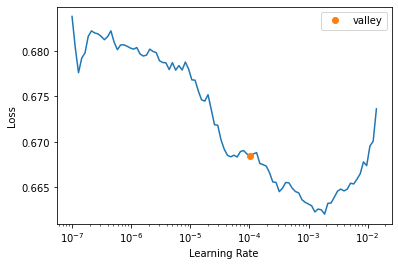

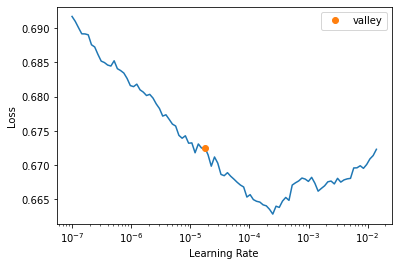

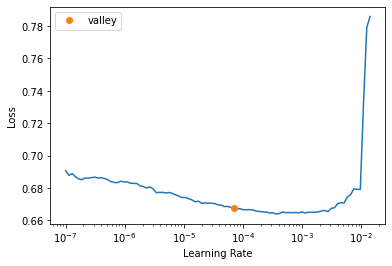

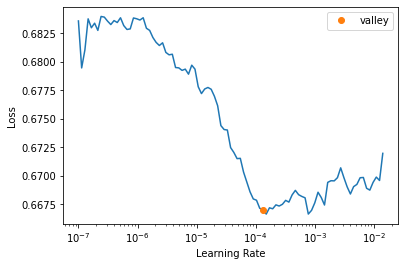

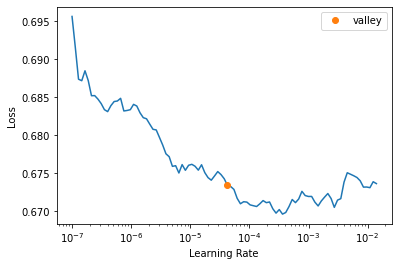

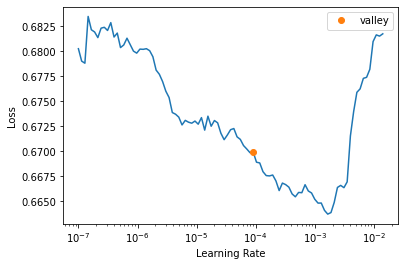

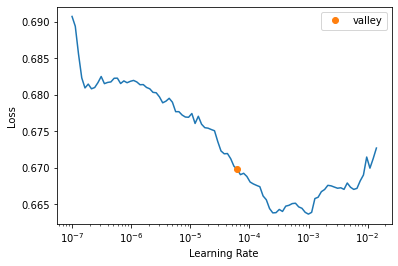

In [16]:
preds = []
val_preds = []

for i in range(N_FOLDS - 1):
    print(f'Swin - Training fold {i}')
    
    fold = get_fold(i)
    learn = get_learner(fold)
    
    lr = learn.lr_find(end_lr=3e-2)
    learn.fit_one_cycle(EPOCHS, lr.valley, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=PATIENCE)]) 
    
    test_dl = fold.test_dl(test_df)
    pred, _ = learn.tta(dl=test_dl, n=5, beta=0)
    preds.append(pred)
    
    val_dl = fold.test_dl(final_val_df)
    val_pred, _ = learn.tta(dl=val_dl, n=5, beta=0)
    val_preds.append(val_pred)
    
    del learn
    torch.cuda.empty_cache()
    gc.collect()
    
swin_preds = np.mean(np.stack(preds), axis=0)*100
swin_val_preds = np.mean(np.stack(val_preds), axis=0)*100

In [17]:
train_metadata_path = dataset_path/'train.csv'
test_metadata_path = dataset_path/'test.csv'

train_metadata = pd.read_csv(train_metadata_path).sort_values(by='Id')

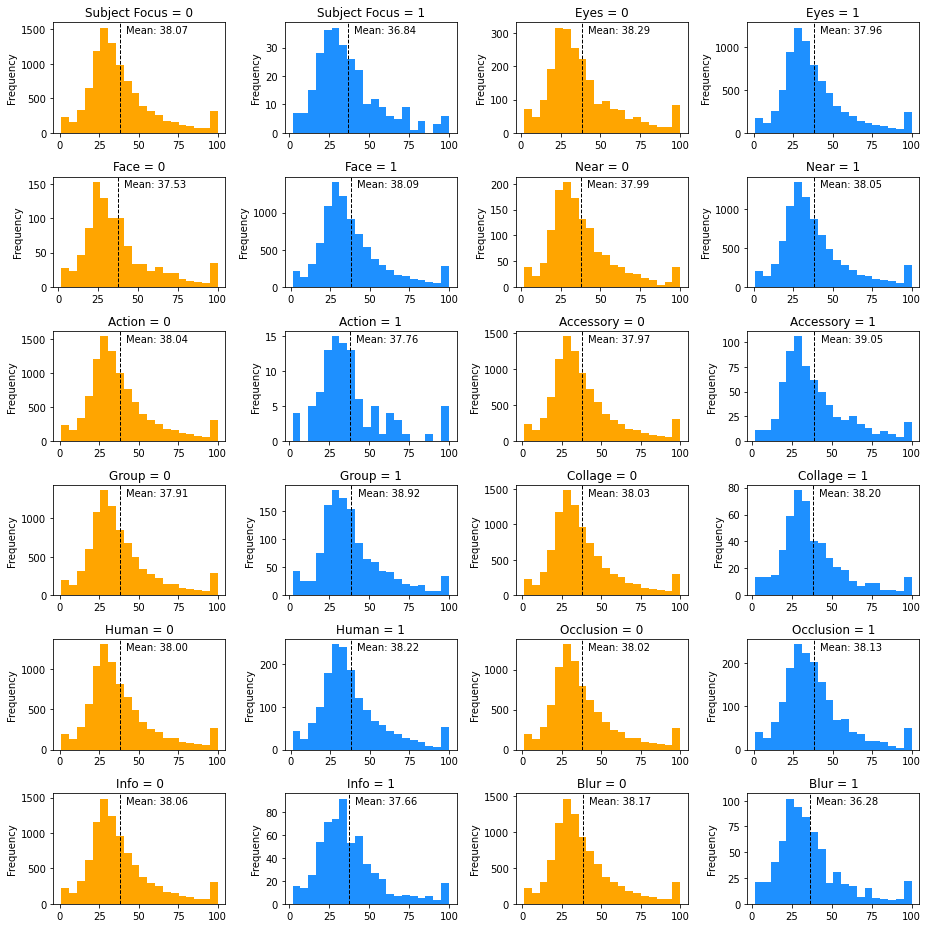

In [18]:
def attr_distribution(df, attr, value, color="dodgerblue"):
    x = df.loc[df[attr] == value]['Pawpularity']
    x.plot(kind='hist', bins=20, title=f'{attr} = {value}', color=color, xlabel='Pawpularity')

    _, max_ylim = plt.ylim()
    plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(x.mean()))

fig = plt.figure(figsize=(13, 13))
columns = 4
rows = 6
set = 1

for attr in train_metadata.columns:
    if attr not in ('Id', 'Pawpularity', 'Bin'):
        fig.add_subplot(rows, columns, set)
        attr_distribution(train_metadata, attr, 0, color='orange')
        fig.add_subplot(rows, columns, set + 1)
        attr_distribution(train_metadata, attr, 1)
        set += 2

plt.tight_layout()

In [19]:
def split_fold(df, fold):
    train = df.loc[df['Id'].isin(train_df[train_df['fold'] != fold]['Id'].values)]
    val = df.loc[df['Id'].isin(train_df[train_df['fold'] == fold]['Id'].values)]
    return train, val

In [20]:
train_metadata_val = train_metadata.loc[train_metadata['Id'].isin(final_val_df['Id'].values)]
train_metadata_val.sort_values('Id', inplace=True)
y_final_val_xgb = train_metadata_val['Pawpularity']
X_final_val_xgb = train_metadata_val.iloc[:,2:-1]

test_metadata = pd.read_csv(test_metadata_path).sort_values(by='Id')
X_test = test_metadata.iloc[:,2:]

/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [21]:
pca = PCA(n_components=4)
pca.fit(X_final_val_xgb)
X_final_val_xgb = X_final_val_xgb.join(pd.DataFrame(pca.transform(X_final_val_xgb), index=X_final_val_xgb.index).add_prefix('pca_'))

pca = PCA(n_components=4)
pca.fit(X_test)
X_test = X_test.join(pd.DataFrame(pca.transform(X_test), index=X_test.index).add_prefix('pca_'))

In [22]:
preds = []
val_preds = []

for i in range(N_FOLDS - 1):
    print(f'XGB - Training fold {i}')

    train, val = split_fold(train_metadata, i)

    y_train_xgb = train['Pawpularity']
    X_train_xgb = train.iloc[:,2:-1]

    y_val_xgb = val['Pawpularity']
    X_val_xgb = val.iloc[:,2:-1]

    pca = PCA(n_components=4)
    pca.fit(X_train_xgb)
    X_train_xgb = X_train_xgb.join(pd.DataFrame(pca.transform(X_train_xgb), index=X_train_xgb.index).add_prefix('pca_'))

    pca = PCA(n_components=4)
    pca.fit(X_val_xgb)
    X_val_xgb = X_val_xgb.join(pd.DataFrame(pca.transform(X_val_xgb), index=X_val_xgb.index).add_prefix('pca_'))

    params = {
        'max_depth': 3,
        'n_estimators': 400,
        'min_child_weight': 2,
        'colsample_bytree': 0.5696,
        'subsample': 0.5389,
        'eta': 0.3116,
        'objective': 'reg:squarederror',
        'seed': SEED
    }

    model = XGBRegressor(**params, n_jobs=-1)

    fit_params = {
        'eval_metric': 'rmse',
        'eval_set': [(X_train_xgb, y_train_xgb), (X_val_xgb, y_val_xgb)],
        'early_stopping_rounds': 400,
        'verbose': False
    }

    model.fit(X_train_xgb, y_train_xgb, **fit_params)
    preds.append(model.predict(X_test))
    val_pred = model.predict(X_final_val_xgb)
    val_preds.append(val_pred)
    print(f'RMSE: {np.sqrt(mean_squared_error(val_pred, y_final_val_xgb))}\n')

xgb_preds = np.mean(np.stack(preds), axis=0)
xgb_val_preds = np.mean(np.stack(val_preds), axis=0)

XGB - Training fold 0
RMSE: 20.185151264389532

XGB - Training fold 1
RMSE: 20.39526780191251

XGB - Training fold 2
RMSE: 20.437227378745302

XGB - Training fold 3
RMSE: 20.191909834737338

XGB - Training fold 4
RMSE: 20.238335049481854

XGB - Training fold 5
RMSE: 20.18797592230387

XGB - Training fold 6
RMSE: 20.26539336120331

XGB - Training fold 7
RMSE: 20.256968498432588

XGB - Training fold 8
RMSE: 20.158944707825196



In [23]:
print(f'Swin Tranformer RMSE: {np.sqrt(mean_squared_error(swin_val_preds, y_final_val_xgb))}\nXGBoost RMSE: {np.sqrt(mean_squared_error(xgb_val_preds, y_final_val_xgb))}')

Swin Tranformer RMSE: 17.393536356482617
XGBoost RMSE: 20.1644288624226


In [24]:
def objective(trial):
    Swin_w = trial.suggest_float('Swin_w', 0, 1.0)
    
    king_predictions = (swin_val_preds.reshape(-1)*Swin_w + xgb_val_preds*(1-Swin_w))
    
    return np.sqrt(mean_squared_error(king_predictions, y_final_val_xgb))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200, n_jobs=-1)
best_weight = study.best_params

[I 2022-01-05 09:51:48,236] A new study created in memory with name: no-name-f9e72e78-9134-4279-b2b0-42fe93b3b751
/opt/conda/lib/python3.7/site-packages/optuna/study/study.py:397: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  FutureWarning,
[I 2022-01-05 09:51:48,247] Trial 0 finished with value: 19.02136020343942 and parameters: {'Swin_w': 0.23651960369205527}. Best is trial 0 with value: 19.02136020343942.
[I 2022-01-05 09:51:48,253] Trial 1 finished with value: 18.287873264557785 and parameters: {'Swin_w': 0.43017444393717497}. Best is trial 1 with value: 18.287873264557785.
[I 2022-01-05 09:51:48,255] Trial 2 finished with value: 17.997106285054493 and parameters: {'Swin_w': 0.52710792613542}. Best is trial 2 with value: 17.997106285054493.
[I 2022-01-05 09:51:48,260] Trial 3 finished with value: 18.47535035486701 and parameters: {'Swin_w': 0.3753851427181035}. Best

In [25]:
best_weight

{'Swin_w': 0.9655184195632673}

In [26]:
test_predictions = pd.DataFrame()
test_predictions['Id'] = test_metadata.Id
test_predictions['Pawpularity'] = (swin_preds*best_weight['Swin_w']).reshape(-1) + xgb_preds*(1-best_weight['Swin_w'])
test_predictions.to_csv('submission.csv', index=False)
test_predictions.head(8)

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,43.129555
1,43a2262d7738e3d420d453815151079e,43.125916
2,4e429cead1848a298432a0acad014c9d,43.350185
3,80bc3ccafcc51b66303c2c263aa38486,43.507385
4,8f49844c382931444e68dffbe20228f4,42.980892
5,b03f7041962238a7c9d6537e22f9b017,43.144234
6,c978013571258ed6d4637f6e8cc9d6a3,43.381550
7,e0de453c1bffc20c22b072b34b54e50f,43.405956
